# SEPTA Subway Zoning Analysis and Ridership Model
## Summary

This Jupyter Notebook document serves as a project workspace for analyzing and visualizing data using Python. It contains multiple cells with code snippets that can be executed independently. The notebook utilizes various libraries such as pandas, numpy, matplotlib, seaborn, and geopandas for data manipulation, analysis, and visualization.

The purpose of this project is to demonstrate how to work with Jupyter Notebook and showcase different techniques for data analysis and visualization. Each cell contains a specific task or analysis, and the markdown cells provide explanations and documentation for the workflow.

Feel free to explore the code cells and markdown cells to understand the steps involved in the data analysis process. Execute the code cells in the desired order to obtain the results and visualizations.

Happy coding!

## Data Wrangling
Although primarily based in Philadelphia County, SEPTA subway stops do venture into or next to neighboring Bucks and Delaware Counties. As such, it is neccesary to gather zoning data from all three counties. Fortunately, all of the counties have easily downloadable zoning maps, unfortunately in Delaware and Bucks counties' zoning codes are determined by indiviudal jurisdictions (townships, boroughs etc.). The data is messy and requires looking at each individual jurisidictions' zoning code to determine the general category of zoning. Philadelphia has a unified zoning code, so it is easier to assimilate each code into a category. 

In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

### Data Sources:  
Ridership Data: [SEPTA's FY 2023 Route Statistics](https://planning.septa.org/wp-content/uploads/2023/09/2023-ROUTE-STATS-WEB-1.pdf)  
Station Data: [SEPTA Open Data Portal](https://data-septa.opendata.arcgis.com/datasets/1e7754ca5f7d47e480a628e282466428_0/explore?location=40.009335%2C-75.214863%2C11.65)  
Philadelphia Zoning: [City of Philadelphia OpenMaps Dashboard](https://openmaps.phila.gov/)  
Bucks County Zoning: [Bucks County Maps & Data Portal](https://maps.buckscounty.gov/datasets/1f914346ed824eb58f4ce7cbe2b66cce)  
Delware County Zoning: [Delaware County Open Data hub](https://delaware-county-pennsylvania-dcpd.hub.arcgis.com/datasets/67e0df30839247f9866177d472cc6d4d_0/explore)  

In [14]:
ridership = pd.read_csv('/Users/owenmcginley/Documents/Summer Projects/Septa_Subway_Ridership.csv')
stations = gpd.read_file('/Users/owenmcginley/Documents/Summer Projects/Metro_Stations')
philly_zoning = gpd.read_file('/Users/owenmcginley/Documents/Summer Projects/Zoning_BaseDistricts')
bucks_zoning = gpd.read_file('/Users/owenmcginley/Documents/Summer Projects/Bucks_County_Municipal_Zoning')
delco_zoning = gpd.read_file('/Users/owenmcginley/Documents/Summer Projects/Delaware_County_Zoning')



In [15]:
zoning = pd.concat([philly_zoning, bucks_zoning, delco_zoning])
zoning['Combined_Zoning'] = zoning['ZONINGGROU'].fillna('') + zoning['Zoning'].fillna('')
zoning = zoning.drop(['ZONINGGROU', 'Zoning'], axis=1)

In [16]:
zoning_categories = {
    "RSD-1": ("Residential Zoning Districts", "Single-Family Detached"),
    "RSD-2": ("Residential Zoning Districts", "Single-Family Detached"),
    "RSD-3": ("Residential Zoning Districts", "Single-Family Detached"),
    "RSA-1": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-2": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-3": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-4": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-5": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-6": ("Residential Zoning Districts", "Single-Family Attached"),
    "RM-1": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RM-2": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RM-3": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RM-4": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RMX-1": ("Residential Zoning Districts", "Mixed-Use Residential"),
    "RMX-2": ("Residential Zoning Districts", "Mixed-Use Residential"),
    "RMX-3": ("Residential Zoning Districts", "Mixed-Use Residential"),
    "RTA-1": ("Residential Zoning Districts", "Two-Family Residential"),
    "RTA-2": ("Residential Zoning Districts", "Two-Family Residential"),
    "CMX-1": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "CMX-2": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "CMX-2.5": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "CMX-3": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "CMX-4": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "CMX-5": ("Commercial Zoning Districts", "Center City Commercial"),
    "CA-1": ("Commercial Zoning Districts", "Auto-Oriented Commercial"),
    "CA-2": ("Commercial Zoning Districts", "Auto-Oriented Commercial"),
    "I-1": ("Industrial Zoning Districts", "Light and Medium Industrial"),
    "I-2": ("Industrial Zoning Districts", "Light and Medium Industrial"),
    "I-3": ("Industrial Zoning Districts", "Heavy Industrial"),
    "I-P": ("Industrial Zoning Districts", "Port Industrial"),
    "IRMX": ("Industrial Zoning Districts", "Industrial Mixed-Use"),
    "ICMX": ("Industrial Zoning Districts", "Industrial Mixed-Use"),
    "SP-INS": ("Special Purpose Zoning Districts", "Institutional"),
    "SP-CIV": ("Special Purpose Zoning Districts", "Civic, Educational and Medical"),
    "SP-ENT": ("Special Purpose Zoning Districts", "Entertainment"),
    "SP-PO-A": ("Special Purpose Zoning Districts", "Parks and Open Spaces"),
    "SP-PO-P": ("Special Purpose Zoning Districts", "Parks and Open Spaces"),
    "SP-STA": ("Special Purpose Zoning Districts", "Sports Stadium"),
    "SP-AIR": ("Special Purpose Zoning Districts", "Airport")
}
philly_zoning['LONG_CODE'] = philly_zoning['LONG_CODE'].astype(str)
philly_zoning['General_Category'] = philly_zoning['LONG_CODE'].map(zoning_categories).str[0]
philly_zoning['Specific_Category'] = philly_zoning['LONG_CODE'].map(zoning_categories).str[1]
philly_zoning.head()

,OBJECTID,CODE,CITYCOR,LONG_CODE,ZONINGGROU,PENDING,PENDINGBIL,PENDINGB_1,SUNSET_DAT,SUNSETBILL,SUNSETBI_1,Shape__Are,Shape__Len,geometry,General_Category,Specific_Category
0,1,SPPOA,0.0,SP-PO-A,Special Purpose,No,N/A,N/A,None,N/A,N/A,3371.062500,257.688146,"POLYGON ((-75.21633 39.95295, -75.21673 39.953...",Special Purpose Zoning Districts,Parks and Open Spaces
1,2,CMX2,0.0,CMX-2,Commercial/Commercial Mixed-Use,No,N/A,N/A,None,N/A,N/A,159.539062,63.896038,"POLYGON ((-75.14301 39.99895, -75.14299 39.998...",Commercial Zoning Districts,Neighborhood Commercial
2,3,RSA5,0.0,RSA-5,Residential/Residential Mixed-Use,No,N/A,N/A,None,N/A,N/A,1721.378906,182.886474,"POLYGON ((-75.06130 40.01405, -75.06135 40.014...",Residential Zoning Districts,Single-Family Attached
3,4,CMX1,0.0,CMX-1,Commercial/Commercial Mixed-Use,No,N/A,N/A,None,N/A,N/A,137.417969,55.579486,"POLYGON ((-75.10094 39.98413, -75.10097 39.984...",Commercial Zoning Districts,Neighborhood Commercial
4,5,CMX2,0.0,CMX-2,Commercial/Commercial Mixed-Use,No,N/A,N/A,None,N/A,N/A,524.609375,92.058804,"POLYGON ((-75.12863 40.01916, -75.12854 40.019...",Commercial Zoning Districts,Neighborhood Commercial


In [17]:
stations = stations[~(stations['Route'] == 'Norristown Highspeed Line')]
stations.head()
stations = stations.to_crs("EPSG:3347")
zoning = zoning.to_crs("EPSG:3347")
philly_zoning = philly_zoning.to_crs("EPSG:3347")


<Axes: >

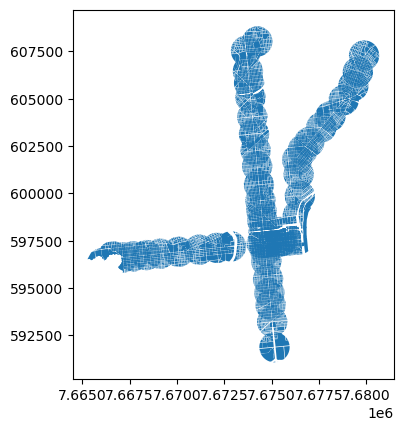

In [18]:
stations['Station'] = np.where(stations['Station'].duplicated(), stations['Station'] + ' ' + stations['Route'], stations['Station'])

metro_stations_buffered = stations.copy()
metro_stations_buffered['geometry'] = stations.geometry.buffer(800)  # Buffer by 800 meters

zoning_near_metro_stations = gpd.overlay(philly_zoning, metro_stations_buffered, how='intersection')
zoning_near_metro_stations.head()


zoning_near_metro_stations.plot()